# 毕设说明书
---

## 地图匹配，将充电需求对应在路网图中

1.将充电需求对应在路网图中，路网图为二维平面，充电需求由车辆产生，根据充电需求产生的地址将其对应到路网图中的点，所述点称为需求点。
所述需求点从城市中车辆停留时间较长的位置产生，包括以下信息：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程。

In [ ]:
'''
#1 —— 一次性执行
#t —— 测试单元，可删除
'''

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import truncnorm
import math

随机地图数据（包括地图块类型：小区、办公区、商贸区），地图设置为$1000\times1000$大小，其中住宅区占比：30%，办公区占比：10%,商贸区占比：5%

0-没有需求区域，1-小区，2-办公区，3-商贸区

In [2]:
# 常量定义
map_size = 100 #地图大小
map_step = 20  #划分地图

In [50]:
#1 使用随机直线划分格子
map_roll = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
map_cul = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
print(map_roll.size)
print(map_cul.size)

19
19


In [51]:
#1 写入文件 
np.savetxt('data/map_roll.txt', map_roll, fmt='%d', delimiter=',')
np.savetxt('data/map_cul.txt', map_cul, fmt='%d', delimiter=',')

In [4]:
# 从文件中读取
map_roll = np.loadtxt('data/map_roll.txt', delimiter=',', dtype=int)
map_roll = np.append(map_roll, map_size)
#map_roll = np.insert(map_roll, 0, 0)
map_cul = np.loadtxt('data/map_cul.txt', delimiter=',', dtype=int)
#map_cul = np.insert(map_cul, 0, 0)
map_cul = np.append(map_cul, map_size)

In [15]:
#t
print(map_cul)

[  3  29  32  34  38  43  46  57  60  61  72  80  82  83  84  87  93  94
  98 100]


In [183]:
#1 随机区域
map_rate = [0.55, 0.3, 0.1, 0.05]
map_x = np.arange(4)
map_distribution = np.random.choice(a=map_x, size=map_step**2, replace=True, p=map_rate)

In [186]:
#1 将区域信息写入文件
np.savetxt('data/map_distribution.txt', map_distribution, fmt='%d', delimiter=',')

In [5]:
# 读取区域
map_distribution = np.loadtxt('data/map_distribution.txt', delimiter=',', dtype=int)

In [188]:
#t 看比例
print(sum(map_distribution==0)/map_step**2)
print(sum(map_distribution==1)/map_step**2)
print(sum(map_distribution==2)/map_step**2)
print(sum(map_distribution==3)/map_step**2)

0.5425
0.3075
0.1075
0.0425


In [184]:
#1 将地图赋值     

mmap = np.ones((map_size,map_size), dtype=np.int) #地图

x_b = 0
y_b = 0
it_mapd = 0
for y_e in map_cul:
    for x_e in map_roll:
        mmap[x_b:x_e, y_b:y_e] *= map_distribution[it_mapd]
        x_b = x_e
        it_mapd += 1
    y_b = y_e

In [189]:
#1 将地图存入文件
np.savetxt('data/mmap.txt', mmap, fmt='%d', delimiter=',')

In [6]:
# 读取地图
mmap = np.loadtxt('data/mmap.txt', delimiter=',', dtype=int)

In [191]:
#t 查看每种区域的地图占比
print(sum(sum(mmap==0))/map_size**2)
print(sum(sum(mmap==1))/map_size**2)
print(sum(sum(mmap==2))/map_size**2)
print(sum(sum(mmap==3))/map_size**2)

0.5964
0.2666
0.1032
0.0338


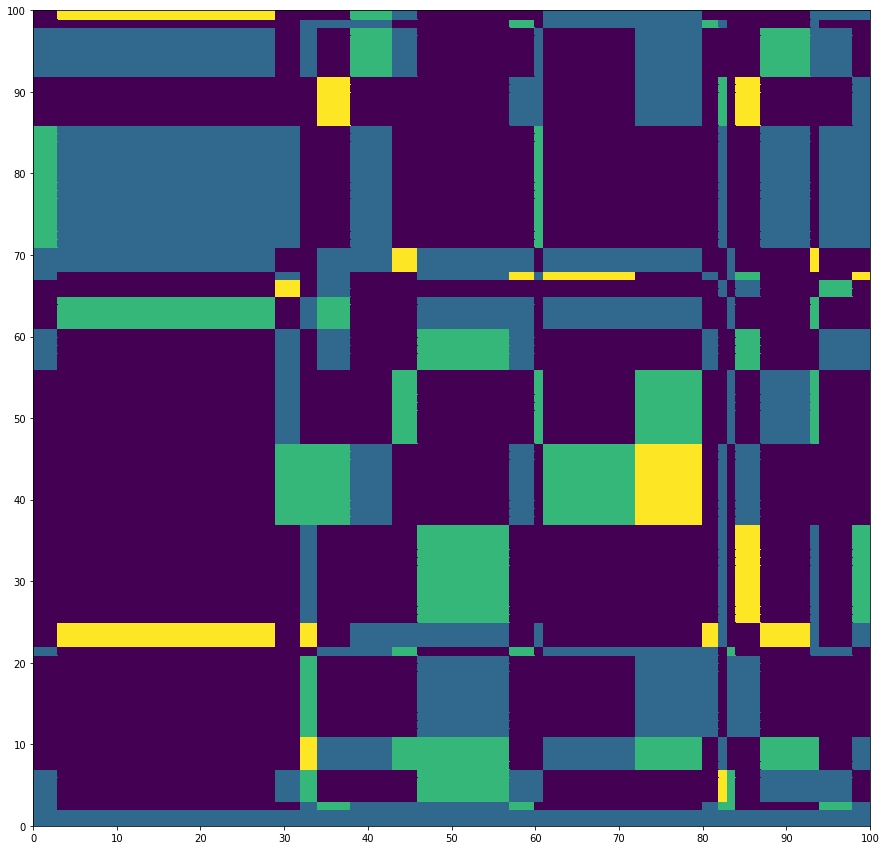

In [192]:
#t 将地图画出来
'''
0-其他区域-深深绿
1-住宅区-深绿
2-办公区-绿色
3-商贸区-黄色
'''
plt.figure(figsize=(15,15))
plt.pcolormesh(mmap,edgecolors='face')
#把x轴的刻度间隔设置为1，并存在变量里
x_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
y_major_locator=MultipleLocator(10)
#ax为两条坐标轴的实例
ax=plt.gca()
#把x轴的主刻度设置为50的倍数
ax.xaxis.set_major_locator(x_major_locator)
#把y轴的主刻度设置为50的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

随机车辆，地图类型对需求产生的时间要求：
1. 住宅区：车辆需求点产生时间多半在中午和夜晚，时间17:00-21:00~7:00-9:00和11:00-12:00~13:30-14:00
2. 办公区：车辆需求点产生时间多半在上午和下午，时间7:00-9:00~11:00-12:00和13:30-14:00~17:00-21:00
3. 商贸区：时间8:00~21:00，时间段多数在2小时以上
4. 其他区域：时间不固定

随机的变量：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程

随机车辆4000，其中2500遵循上班时间，1000遵循购物娱乐时间，500遵循在家时间

In [193]:
#1 随机时间
'''
car_cate
0-上班时间
时间：住宅区+办公区
地点：住宅+办公

1-娱乐时间
时间：住宅区+商贸区
地点：住宅+商贸

2-在家时间
时间：全天
地点：住宅
'''
#截断正态分布函数
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

car_num_0 = 2500
car_num_1 = 1000
car_num_2 = 500

# 上班时间
def cars_0():
    # 随机时间
    time_point_1_normal = get_truncated_normal(8.5, 1.5, 5, 10)
    time_point_1 = time_point_1_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_2_normal = get_truncated_normal(11.5, 0.5, 11, 12)
    time_point_2 = time_point_2_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_3_normal = get_truncated_normal(14, 0.5, 13, 15)
    time_point_3 = time_point_3_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_4_normal = get_truncated_normal(19, 1.5, 17, 21)
    time_point_4 = time_point_4_normal.rvs(car_num_0).reshape(car_num_0, 1)
    # 车辆id，为列向量
    car_id = np.arange(0,car_num_0).reshape(car_num_0, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_0, replace=True)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_2_index = np.random.choice(a=np.argwhere(mmap==2).shape[0], size=car_num_0, replace=True)#办公地址
    addr_2 = [np.argwhere(mmap==2)[i] for i in addr_2_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_0*4).reshape(car_num_0*4,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    
    car_id_con = np.concatenate((np.concatenate((car_id, car_id)), 
                                 np.concatenate((car_id, car_id))))
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), 
                                     np.concatenate((time_point_3, time_point_4))))
    addr_con = np.concatenate((np.concatenate((addr_2, addr_1)),
                               np.concatenate((addr_2, addr_1))))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_0_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_0_request = np.concatenate((car_0_request, remain_licheng), axis=1)
    # np.savetxt('data/car_0_request_test.txt', car_0_request, fmt='%f', delimiter=',')  
    df_car_0_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_0_request_read['充电需求产生的时间'] = time_point_con
    df_car_0_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request_read['预估充电时长'] = charge_time
    df_car_0_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_0_request_read.to_csv('data/df_car_0_request_read.csv')
    
    df_car_0_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_0_request['time_point'] = time_point_con
    df_car_0_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request['charge_time'] = charge_time
    df_car_0_request['remain_licheng'] = remain_licheng
    df_car_0_request.to_csv('data/df_car_0_request.csv')
    return df_car_0_request

# 娱乐时间
def cars_1():
    # 随机时间
    time_point_1_normal = get_truncated_normal(11, 1, 9, 13) # 去商场的时间点1
    time_point_1 = time_point_1_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_point_2_normal = get_truncated_normal(15, 2, 13, 19) # 去商场的时间点2
    time_point_2 = time_point_2_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_last_normal = get_truncated_normal(4, 1.5, 2, 11)
    time_last = time_last_normal.rvs(car_num_1).reshape(car_num_1, 1)
    time_point_temp = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_last), axis=1)
    time_point_3 = np.zeros((car_num_1, 1))  #回住宅的时间
    tp_i = 0
    for tpt in time_point_temp: # 24小时制
        time_p = tpt[0]+tpt[1]
        if time_p > 24:
            time_p -= 24
        time_point_3[tp_i] = time_p
        tp_i += 1
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_point_3))
    # 车辆id，为列向量
    car_id = np.arange(car_num_0, car_num_0+car_num_1).reshape(car_num_1, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_1, replace=False)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_3_index = np.random.choice(a=np.argwhere(mmap==3).shape[0], size=car_num_1, replace=True)#商贸地址
    addr_3 = [np.argwhere(mmap==3)[i] for i in addr_3_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_1*2).reshape(car_num_1*2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    car_id_con = np.concatenate((car_id, car_id))
    addr_con = np.concatenate((addr_3, addr_1))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_1_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_1_request = np.concatenate((car_1_request, remain_licheng), axis=1)
    # np.savetxt('data/car_1_request.txt', car_1_request, fmt='%f', delimiter=',')
    df_car_1_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_1_request_read['充电需求产生的时间'] = time_point_con
    df_car_1_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request_read['预估充电时长'] = charge_time
    df_car_1_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_1_request_read.to_csv('data/df_car_1_request_read.csv')
    
    df_car_1_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_1_request['time_point'] = time_point_con
    df_car_1_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request['charge_time'] = charge_time
    df_car_1_request['remain_licheng'] = remain_licheng
    df_car_1_request.to_csv('data/df_car_1_request.csv')
    return df_car_1_request


# 在家时间
def cars_2():
    # 随机时间
    time_point_normal = get_truncated_normal(12, 10, 0, 24)
    time_point = time_point_normal.rvs(car_num_2).reshape(car_num_2, 1)
    # 车辆id，为列向量
    car_id = np.arange(car_num_0+car_num_1,car_num_0+car_num_1+car_num_2).reshape(car_num_2, 1)
    # 随机地址
    addr_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_2, replace=True)#住宅地址
    addr = [np.argwhere(mmap==1)[i] for i in addr_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_2).reshape(car_num_2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    df_addr_con = pd.DataFrame(addr, columns = ['x','y'])
    df_car_2_request_read = pd.DataFrame(car_id, columns = ['车辆id'])
    df_car_2_request_read['充电需求产生的时间'] = time_point
    df_car_2_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request_read['预估充电时长'] = charge_time
    df_car_2_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_2_request_read.to_csv('data/df_car_2_request_read.csv')
    
    df_car_2_request = pd.DataFrame(car_id, columns = ['car_id'])
    df_car_2_request['time_point'] = time_point
    df_car_2_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request['charge_time'] = charge_time
    df_car_2_request['remain_licheng'] = remain_licheng
    df_car_2_request.to_csv('data/df_car_2_request.csv')
    return df_car_2_request

In [194]:
#1 写入文件
df_car_request = cars_0().append(cars_1()).append(cars_2())
df_car_request.to_csv('data/df_car_request.csv')

In [3]:
# 读取充电需求数据
df_car_request = pd.read_csv('data/df_car_request.csv', engine='python')
df_car_request.drop(df_car_request.columns[0], axis=1, inplace=True) # 删除第一列

## 预测城市充电需求，确定充电热区

该步骤是使用基于区域充电需求量的聚类算法实现的，具体步骤如下：
1. 数据清洗，由于会出现多个充电需求对应到同一需求点的情况，需要统计每个充电需求中预估的充电时长，之后计算每个需求点的总预估的充电时长作为该需求点的需求分数，公式如下：
$$SC_p=\sum_{i=1}^{n}ST_i$$
其中$SC_p$表示需求点$p$的需求分数，$ST_i$表示对应到需求点$p$的第$i$个充电需求中的预估充电时长
2. 删除需求分数过低的需求点，根据预先设置的阈值，删除需求分数低于阈值的需求点；
3. 使用K-means算法将需求点进行聚类，得到不同密度的簇，即充电热区，其代表着有一定充电需求的区域。

其中，步骤3中聚类个数K使用肘部法则来确定，将各个簇内的样本点到所在簇质心的距离平方和（SSE）作为性能度量，越小则说明各个类簇越收敛。但不是SSE越小越好，肘部法则就是在类簇数量与SSE之间寻求一个平衡点，具体步骤如下：

(1)指定一个i值，即可能的最大类簇数；

(2) 然后将类簇数从1开始递增，一直到$i$，计算出$i$个$SSE$，公式如下：
$$SSE=\sum_{k=1}^{k}\sum_{i\epsilon C_k}^{i}\lvert x_i-\mu k \rvert$$
其中，$\mu k$是第k个质心的位置

(3)通过画出K-SSE曲线，找出下降途中的拐点，即可较好的确定K值。

In [17]:
#1 1.数据清洗
def str_to_np(str): #将字符串转换为numpy数组
    str_temp = str[1:-1].strip().split(' ')
    if len(str_temp) > 2:
        str_temp[1] = str_temp[2]
        del str_temp[2]
    str_temp[0] = int(str_temp[0])
    str_temp[1] = int(str_temp[1])
    str_temp = np.asarray(str_temp)
    return str_temp

P_set = set(df_car_request['addr']) #需求点集合(dtype='object')
P_np = np.asarray([str_to_np(dfp) for dfp in P_set]) #需求点集合(dtype='np.array')
SCP_np = np.zeros(len(P_set)) #需求点对应的需求分数
it_scp = 0 #迭代数
for p in P_set: #计算需求分数
    it_df_p = df_car_request[df_car_request['addr'] == p]
    scp = it_df_p['charge_time'].sum()
    SCP_np[it_scp] = scp
    it_scp += 1
    
df_p_np = pd.DataFrame(P_np, columns = ['x','y'])

df_scp = pd.DataFrame(df_p_np.apply(lambda r: tuple(r), axis=1).apply(np.array), columns=['addr'])
SCP_np.reshape(len(P_set), 1)
df_scp['scp'] = SCP_np

# 2.删除需求分数过低的需求点（小于1的）
del_labels = np.where(SCP_np < 3)
del_labels = del_labels[0]
df_scp = df_scp.drop(del_labels)
# 将需求存入文件
df_scp.to_csv('data/df_scp.csv') 

In [16]:
#t
print('需求分数小于1.5的占比：'+str(sum(SCP_np < 1.5)*100/len(SCP_np))+'%')
print('需求分数小于2.5的占比：'+str(sum(SCP_np < 2.5)*100/len(SCP_np))+'%')
print('需求分数小于3的占比：'+str(sum(SCP_np < 3)*100/len(SCP_np))+'%')
print('需求分数小于4的占比：'+str(sum(SCP_np < 4)*100/len(SCP_np))+'%')
print('需求分数小于5的占比：'+str(sum(SCP_np < 5)*100/len(SCP_np))+'%')

需求分数小于1.5的占比：7.0393374741200825%
需求分数小于2.5的占比：20.28985507246377%
需求分数小于3的占比：28.867199053534456%
需求分数小于4的占比：43.0050280981958%
需求分数小于5的占比：54.037267080745345%


In [18]:
# 读取df_scp
def str_to_np(df_scp_0): #将df_scp中地址转换为numpy数组
    scp_0_array = np.zeros((len(df_scp_0), 2))
    it = 0
    for df_0 in df_scp_0:
        str_temp = df_0[1:-1].strip().split(' ')
        if len(str_temp) > 2:
            str_temp[1] = str_temp[2]
            del str_temp[2]
        str_temp[0] = int(str_temp[0])
        str_temp[1] = int(str_temp[1])
        scp_0_array[it] = [str_temp[0], str_temp[1]]
        it += 1
    return scp_0_array

df_scp = pd.read_csv('data/df_scp.csv', engine='python')
df_scp.drop(df_scp.columns[0], axis=1, inplace=True) # 删除第一列
np_df_scp_addr = str_to_np(df_scp['addr']) # 需求点地址numpy数组
np_df_scp_scp = np.asarray(df_scp['scp']) # 需求点分数的numpy数组

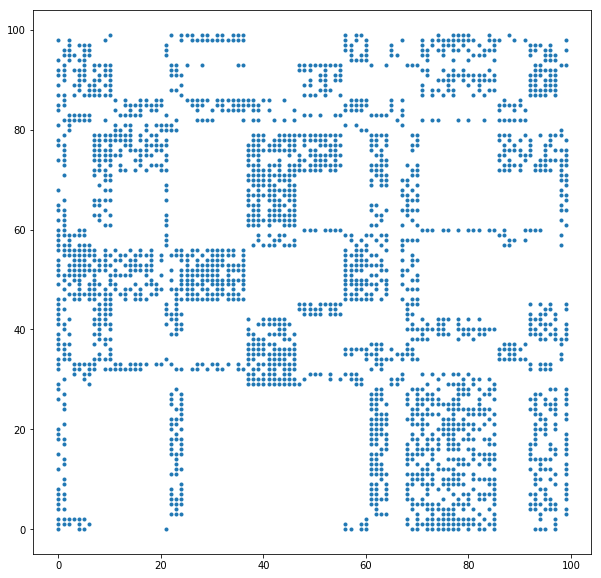

In [19]:
#t 需求点分布
plt.figure(figsize=(10,10))
plt.plot([x[0] for x in np_df_scp_addr], [x[1] for x in np_df_scp_addr], '.')
plt.show()

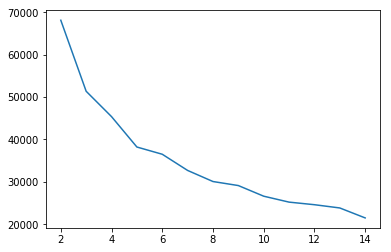

In [26]:
# 聚类 np_df_scp_addr np_df_scp_scp
# num_cluster = 10 #聚类中心的个数

def cal_dis(addr, centroid):
    distence_1 = np.sum(np.sqrt(np.sum(np.square(addr-centroid), axis=1)))
    return distence_1
                            
# 聚类
def clustering(num_cluster):
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(np_df_scp_addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([np_df_scp_addr[i] for i in cluster_centroids_index])
    #print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 30:
        sse = 0
        np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids) # 计算每个点的聚类中心
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            # 取出属于同一聚类中心的点的索引
            index = []
            for i in range(len(np_df_scp_centroids)):
                if np_df_scp_centroids[i][0] == centroid[0] and np_df_scp_centroids[i][1] == centroid[1]:
                    index.append(i)
            addr_temp = np.zeros((len(index), 2))# 簇集合
            it_at = 0
            for i in index:
                addr_temp[it_at] = np_df_scp_addr[i]
                it_at += 1
            addr_temp = np.asarray(addr_temp)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    #print(cluster_centroids)
    return sse    

# 计算每个点到聚类中心的距离，并存入np_df_scp_centroids
def assign(np_df_scp_addr, centroids):
    np_df_scp_centroids = np.zeros((len(np_df_scp_addr), 2))
    it_ndsc = 0
    for addr in np_df_scp_addr:
        distence = np.sqrt(np.sum(np.square(addr-centroids), axis=1))
        np_df_scp_centroids[it_ndsc] = centroids[np.argmin(distence)]
        it_ndsc += 1
    return np_df_scp_centroids
            

def sse():
    sse = []
    for k in range(2, 15):
        sse.append(clustering(k))
    return sse

x = np.arange(2, 15)
plt.figure(size())
plt.plot(x, sse())
plt.show()

In [18]:
a = np.asarray([[1,2],[3,4],[5,6]])
b = np.asarray([[1,3]])
print(np.mean(a,axis=0))
print(a.shape)

[3. 4.]
(3, 2)


## 调整充电热区，确定充电站候选区域

总体方法为融合较小的簇、分割较大的簇，具体步骤如下：
1. 计算充电热区的半径和充电热区之间的距离矩阵；
2. 若某一充电热区和其他充电热区的距离小于r，则以半径r合并充电热区，其中r与电动汽车充满电的续航里程相关，r是为了保证电动汽车的剩余电量可以支撑其行驶到充电站，根据历史数据中电动汽车在该区域的平均剩余电量，可以利用现有方法估算行驶里程l，则$r=l$
3. 若充电热区的半径大于阈值r则在该热区内再次运行K-means算法划分新的充电热区，重复步骤1；
4. 得到充电站候选区域集合。

In [ ]:
# 

## 确定充电站内的充电桩数量

1. 统计候选区域内候选点的停留时长及其时间段（每小时为1个时间段）；
2. 将停留时长除以3作为该候选点在其停留时间段的充电需求值； 
3. 统计候选区域内所有时间段的充电需求和，将其作为候选区域的充电桩数量。

In [ ]:
#

## 利用遗传算法实现最优布局

1. 创建初始种群，在遗传算法中，使用固定长度的二进制串来表示群体中的个体，将n个候选点编号为1-n，并根据是否设置充电站，将染色体上的基因进行编码，由{0，1}组成，0表示不设置充电站，1表示设置充电站；
2. 设置种群的个体适应度函数，个体适应度函数是布局目标的数学表达，考虑两个因素——用户和管理者因素，具体为用户的时间费用（平均行驶时间、充电排队时间）、管理者的建站费用（充电站的个数），公式如下：
$$S=\sum_{i\epsilon C}(\frac{\lambda_1}{num_j}\sum_{j\epsilon C_i}(t_{j1}+t_{j2})+\lambda_2\frac{1}{num_i})$$
其中，$C$表示充电站集合，表示第$i$个充电站，$j$表示选择作为充电目标的电动汽车，$t_{j1}$表示行驶时间，$t_{j2}$表示排队时间，$num_j$和$num_i$分别表示充电站的个数和选择此充电站的电动汽车个数，$\lambda_1$和$\lambda_2$代表用户时间费用和管理者建站费用的系数，通过实验得出，因此，布局目标是用户到达最近充电站的耗时和成电站个数最少。
3. 执行遗传算子不断迭代得到最终解；

In [ ]:
# 